<a href="https://colab.research.google.com/github/ruinalmeida/pytests/blob/master/predict_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Description : Just testing https://medium.com/@randerson112358/stock-price-prediction-using-python-machine-learning-e82a039ac2bb https://www.youtube.com/watch?v=QIUxPv5PJOY

In [3]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
#Get the stock quote 
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-09-10') 
#Show the data 
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.691425
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.759631
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.901293
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.036158
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,13.015480
...,...,...,...,...,...,...
2019-09-04,52.369999,51.830002,52.097500,52.297501,76752400.0,51.783714
2019-09-05,53.492500,52.877499,53.000000,53.320000,95654800.0,52.796162
2019-09-06,53.605000,53.127499,53.512501,53.314999,77449200.0,52.791210


In [6]:
df.shape

(1934, 6)

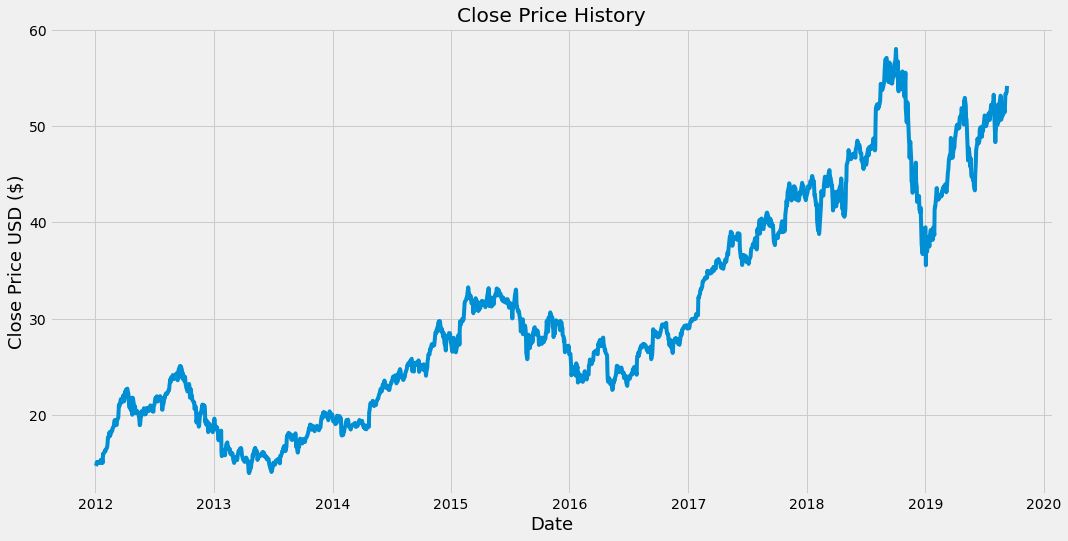

In [8]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [9]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

training_data_len

1548

In [10]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01677525],
       [0.01856624],
       [0.02228596],
       ...,
       [0.89329469],
       [0.89845695],
       [0.91280911]])

In [11]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [12]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [13]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [14]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [15]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1488/1488 [==============================] - 25s 17ms/step - loss: 0.0011


In [17]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [18]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [19]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [20]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [21]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1.435123354043576

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


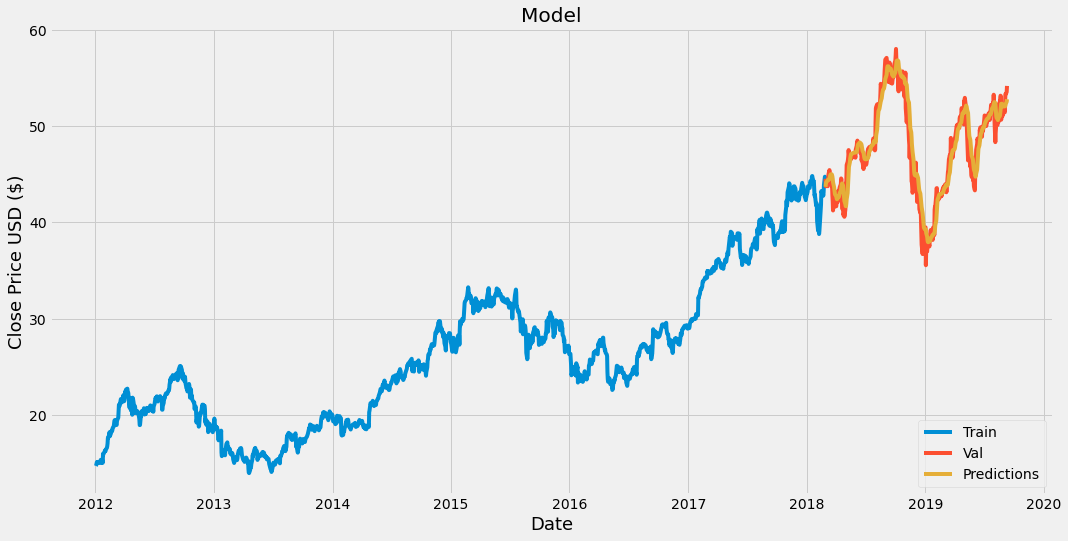

In [22]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [23]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-02-28,44.529999,43.690430
2018-03-01,43.750000,44.009476
2018-03-02,44.052502,44.174831
2018-03-05,44.205002,44.280033
2018-03-06,44.167500,44.358700
...,...,...
2019-09-04,52.297501,52.059475
2019-09-05,53.320000,52.107811
2019-09-06,53.314999,52.298122


In [24]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[67.49608]]


In [25]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    69.934998
Name: Close, dtype: float64
